## **Load training and validation sets**

In [40]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import dlib
from scipy import ndimage
import tarfile
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

%mkdir -p /content/data/
%cd /content/data

/content/data


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# train_path = '/content/drive/My Drive/pretraining/training.tar'
val_path = '/content/drive/My Drive/pretraining/validation.tar'

# Load training set and validation set
for fpath in [val_path]:
  with tarfile.open(fpath) as tar:
    tar.extractall()

The images of the training set should now be loaded at content/data/training and the images of the validation set at content/data/validation.

## **Building training and validation sets**

In [ ]:
class CelebAU(Dataset):
  """CelebAU dataset labeled by presence of action units (AU)"""

  def __init__(self, train=False, intensity=False, transform=None):
    """
    Args:
      - label_csv: Path to the csv file with action unit labels.
      - train: training set if True, otherwise validation set
      - intensity (bool): labels are intensities (between 0 and 5) rather
                          than presence (either 0 or 1).  
      - transform: transform applied to an image input
    """
    self.train = train
    if train:
      label_path = '/content/drive/My Drive/pretraining/train_labels.csv'
      self.root_dir = '/content/data/training'
    else:
      label_path = '/content/drive/My Drive/pretraining/val_labels.csv'
      self.root_dir = '/content/data/validation'
    self.au_frame = pd.read_csv(label_path, index_col=[0])
    if intensity:
      self.label_cols = [' AU01_r', ' AU02_r', ' AU04_r', ' AU05_r', ' AU06_r',
                         ' AU07_r', ' AU09_r', ' AU10_r', ' AU12_r', ' AU14_r',
                         ' AU15_r', ' AU17_r', ' AU20_r', ' AU23_r', ' AU25_r',
                         ' AU26_r', ' AU28_c', ' AU45_r']
    else:
      self.label_cols = [' AU01_c', ' AU02_c', ' AU04_c', ' AU05_c', ' AU06_c',
                         ' AU07_c', ' AU09_c', ' AU10_c', ' AU12_c', ' AU14_c',
                         ' AU15_c', ' AU17_c', ' AU20_c', ' AU23_c', ' AU25_c',
                         ' AU26_c', ' AU28_c', ' AU45_c']
    self.intensity = intensity
    self.transform = transform


  def __len__(self):
    return len(self.au_frame)

  def __getitem__(self, idx):
    # Get image at idx
    image_id = self.au_frame.iloc[idx, 0]
    image_path = self.root_dir + '/' + str(image_id).zfill(6) + '.jpg'
    image = cv2.imread(image_path)
    
    # Get AU labels
    aus = self.au_frame.iloc[idx][self.label_cols]
    aus = np.array(aus, dtype=float)

    if self.transform:
      image = self.transform(image)

    sample = {'image': image, 'labels': aus}

    return sample

In [ ]:
validation_set = CelebAU()

/content/data/validation/026011.jpg
[0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]


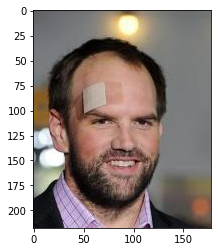

In [ ]:
sample = validation_set[1000]
print(sample['labels'])
im = sample['image']
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [ ]:
dataloader = DataLoader(validation_set, batch_size=5,
                        shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['labels'].size())

    if i_batch == 3:
        break

0 torch.Size([5, 218, 178, 3]) torch.Size([5, 18])
1 torch.Size([5, 218, 178, 3]) torch.Size([5, 18])
2 torch.Size([5, 218, 178, 3]) torch.Size([5, 18])
3 torch.Size([5, 218, 178, 3]) torch.Size([5, 18])


## **Defining the model**

In [43]:
class AUDetector(nn.Module):

  def __init__(self):
    super(AUDetector, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(1, 64, 3), nn.ReLU(),
                               nn.Conv2d(64, 64, 3), nn.ReLU(),
                               nn.MaxPool2d(2, stride=2), nn.Dropout2d(p=0.25))

    self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3), nn.ReLU(),
                               nn.Conv2d(128, 128, 3), nn.ReLU(),
                               nn.MaxPool2d(2, stride=2), nn.Dropout2d(p=0.25))

    self.conv3 = nn.Sequential(nn.Conv2d(128, 256, 3), nn.ReLU(),
                               nn.Conv2d(256, 256, 3), nn.ReLU(),
                               nn.Conv2d(256, 256, 3), nn.ReLU(),
                               nn.MaxPool2d(2, stride=2), nn.Dropout2d(p=0.25))

    self.conv4 = nn.Sequential(nn.Conv2d(256, 256, 3), nn.ReLU(),
                               nn.Conv2d(256, 256, 3), nn.ReLU(),
                               nn.Conv2d(256, 256, 3), nn.ReLU(),
                               nn.MaxPool2d(2, stride=2), nn.Dropout2d(p=0.25))

    self.fc5 = nn.Sequential(nn.Flatten(), nn.Linear(4096, 1024), nn.ReLU(),
                             nn.Dropout(p=0.5))

    self.fc6 = nn.Sequential(nn.Flatten(), nn.Linear(1024, 1024), nn.ReLU(),
                             nn.Dropout(p=0.5))

    self.out = nn.Sequential(nn.Linear(1024, 18), nn.Sigmoid())

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.fc5(x)
    x = self.fc6(x)
    x = self.out(x) 